# 시계열 모델링_따릉이

* 지금까지 배운 것을 복습 합니다.
* Data : 서울 공유 자전거
* 문제 : 2시간 후의 수요를 예측하고자 합니다.
* 최소 2개 이상의 모델을 만들고 성능을 비교해 봅시다.
------

![](https://mediahub.seoul.go.kr/uploads/mediahub/2021/03/RaKqiqgRXyNmYVYymXQIvCjPHpncuhBX.png)

## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, SimpleRNN, LSTM, Flatten, Input
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [ ]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) 데이터로딩

In [ ]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBikeData2.csv'
data = pd.read_csv(path)
data.drop(['Visibility','Solar'], axis = 1, inplace = True)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes


**변수설명**  

* DateTime : year-month-day hh:mi:ss
* Count : 시간대별 수요량
* Temperature : 온도(섭씨)
* Humidity : 습도(%)
* WindSpeed : 풍속(m/s)
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday / No holiday
* FuncDay - Yes / No


In [ ]:
# 데이터 기간은 다음과 같습니다.
data.DateTime.min(), data.DateTime.max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2018-11-30 23:00:00'))

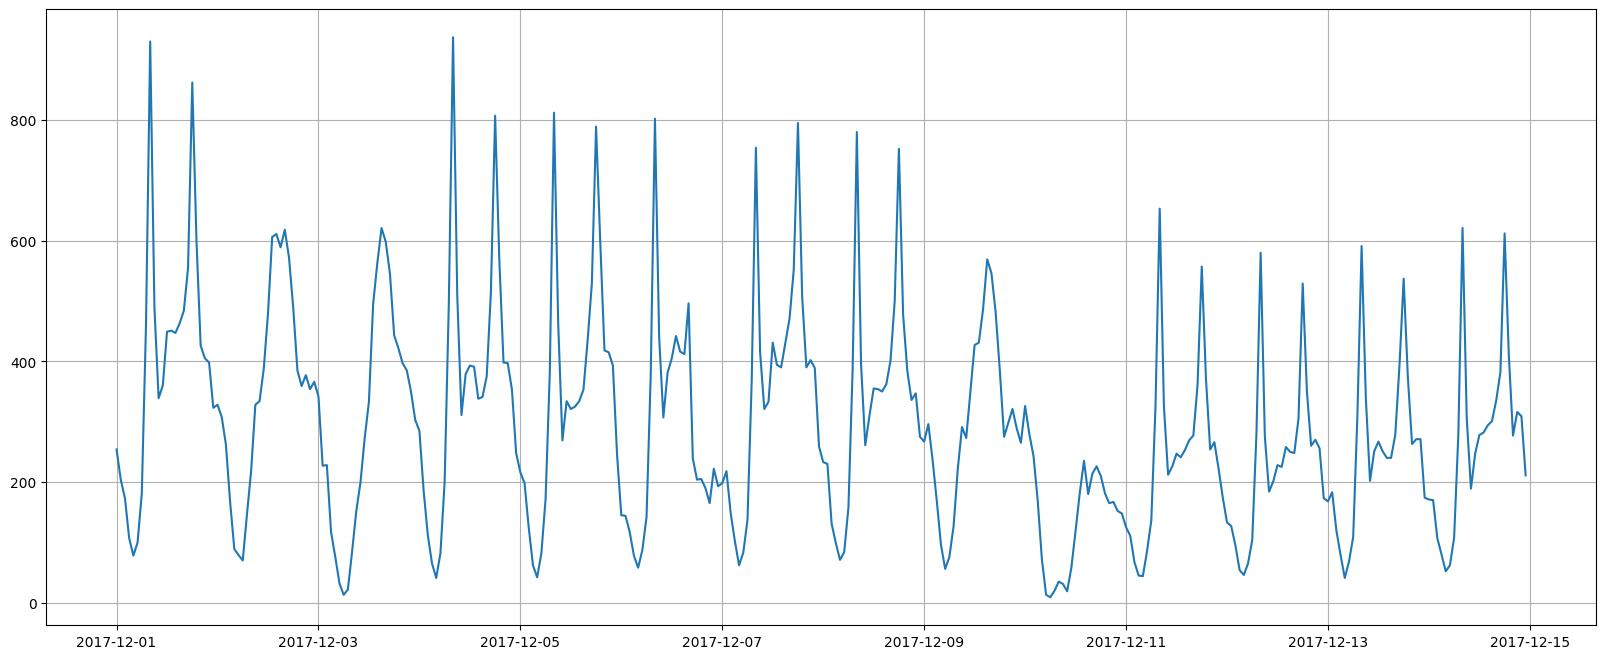

In [ ]:
# 14일 동안의 수요량을 살펴 봅시다.
temp = data[:24*14]
plt.figure(figsize = (20,8))
plt.plot('DateTime', 'Count', data = temp)
plt.grid()
plt.show()

## 2.데이터 준비

### (1) y 만들기
* 2시간 이후의 수요량을 예측해야 합니다.

In [ ]:
data['y'] = data['Count'].shift(-2)
data.head()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes,173.0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes,107.0
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes,78.0
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes,100.0
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes,181.0


In [ ]:
# 2칸을 앞당겼기 때문에 하위 2행의 y값에 NaN이 표시되어 있습니다.
data.tail()

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y
8755,2018-11-30 19:00:00,1003,4.2,34,2.6,0.0,0.0,Autumn,No Holiday,Yes,694.0
8756,2018-11-30 20:00:00,764,3.4,37,2.3,0.0,0.0,Autumn,No Holiday,Yes,712.0
8757,2018-11-30 21:00:00,694,2.6,39,0.3,0.0,0.0,Autumn,No Holiday,Yes,584.0
8758,2018-11-30 22:00:00,712,2.1,41,1.0,0.0,0.0,Autumn,No Holiday,Yes,NaN
8759,2018-11-30 23:00:00,584,1.9,43,1.3,0.0,0.0,Autumn,No Holiday,Yes,NaN


In [ ]:
# 하위 2행은 삭제합니다.
# 하위 2행 제외하고 다시 붓기
data = data[:-2]

### (2) Feature Engineering

In [ ]:
# 요일
data['WeekDay'] = data['DateTime'].dt.dayofweek

# 주말여부
data['WeekEnd'] = np.where(data['WeekDay']>4, 1,0)

# hour
data['Hour'] = data['DateTime'].dt.hour
data.head()

<ipython-input-10-7db56336ddf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WeekDay'] = data['DateTime'].dt.dayofweek
<ipython-input-10-7db56336ddf0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['WeekEnd'] = np.where(data['WeekDay']>4, 1,0)
<ipython-input-10-7db56336ddf0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,DateTime,Count,Temperature,Humidity,WindSpeed,Rainfall,Snowfall,Seasons,Holiday,FuncDay,y,WeekDay,WeekEnd,Hour
0,2017-12-01 00:00:00,254,-5.2,37,2.2,0.0,0.0,Winter,No Holiday,Yes,173.0,4,0,0
1,2017-12-01 01:00:00,204,-5.5,38,0.8,0.0,0.0,Winter,No Holiday,Yes,107.0,4,0,1
2,2017-12-01 02:00:00,173,-6.0,39,1.0,0.0,0.0,Winter,No Holiday,Yes,78.0,4,0,2
3,2017-12-01 03:00:00,107,-6.2,40,0.9,0.0,0.0,Winter,No Holiday,Yes,100.0,4,0,3
4,2017-12-01 04:00:00,78,-6.0,36,2.3,0.0,0.0,Winter,No Holiday,Yes,181.0,4,0,4


### (3) x, y 분리

In [ ]:
target = 'y'
x = data.drop(['DateTime', target], axis = 1)
y = data.loc[:,target]

### (4) 가변수화

In [ ]:
cat_cols = ['Seasons','Holiday','FuncDay', 'WeekDay','Hour']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

### (5) 스케일링

* y 값이 클때는 y도 스케일링 필요

In [ ]:
# x 스케일링
scaler_x = MinMaxScaler()
x_s = scaler_x.fit_transform(x)

In [ ]:
# y는 1차원이므로 수동으로.
y_max, y_min = y.max(), y.min()
y_s = (y - y_min) / (y_max - y_min)

### (6) 3차원 구조 만들기

In [ ]:
timestep = 12
x2, y2 = temporalize(x_s, y_s, timestep)
x2.shape, y2.shape

((8747, 12, 41), (8747,))

### (7) 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 24*14, shuffle = False)

In [ ]:
x_train.shape, y_train.shape

((8411, 12, 41), (8411,))

In [ ]:
x_val.shape, y_val.shape

((336, 12, 41), (336,))

## 3.모델링1



### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
x_train.shape

(8411, 12, 41)

In [ ]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계

In [ ]:
clear_session()

model = Sequential([Input(shape = (timesteps, nfeatures)),
                    SimpleRNN(32, return_sequences = True),
                    SimpleRNN(16, return_sequences = True),
                    SimpleRNN(8),
                    Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 12, 32)              │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 12, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,361 (13.13 KB)

 Trainable params: 3,361 (13.13 KB)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.001), loss='mse')
history = model.fit(x_train, y_train, epochs = 100, batch_size = 128,
                    validation_split=.2).history

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0691 - val_loss: 0.0376
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0159 - val_loss: 0.0255
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0108 - val_loss: 0.0198
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0087 - val_loss: 0.0176
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0073 - val_loss: 0.0159
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0062 - val_loss: 0.0139
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0063 - val_loss: 0.0133
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0058 - val_loss: 0.0140
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0054 - val_loss: 0.0115
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0047 - val_loss: 0.0115
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - val_loss: 0.0106
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

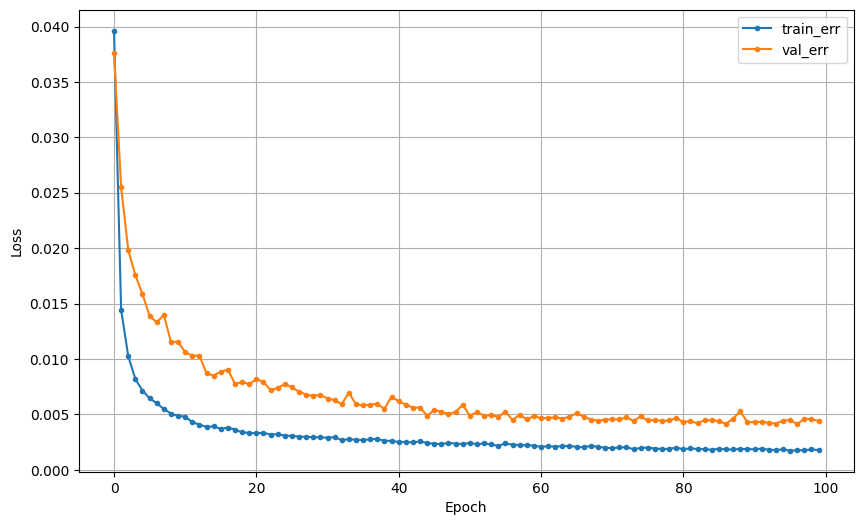

In [ ]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [ ]:
# 예측
pred = model.predict(x_val)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [ ]:
# y를 스케일링 했으므로 돌려놓기
y_val_real = y_val * (y_max-y_min) + y_min
pred_real = pred * (y_max-y_min) + y_min

In [ ]:
# 평가
print(mean_squared_error(y_val_real, pred_real, squared=False))
print(mean_absolute_error(y_val_real, pred_real))
print(mean_absolute_percentage_error(y_val_real, pred_real))

139.48025535943222
104.93842391740708
0.298370425298335


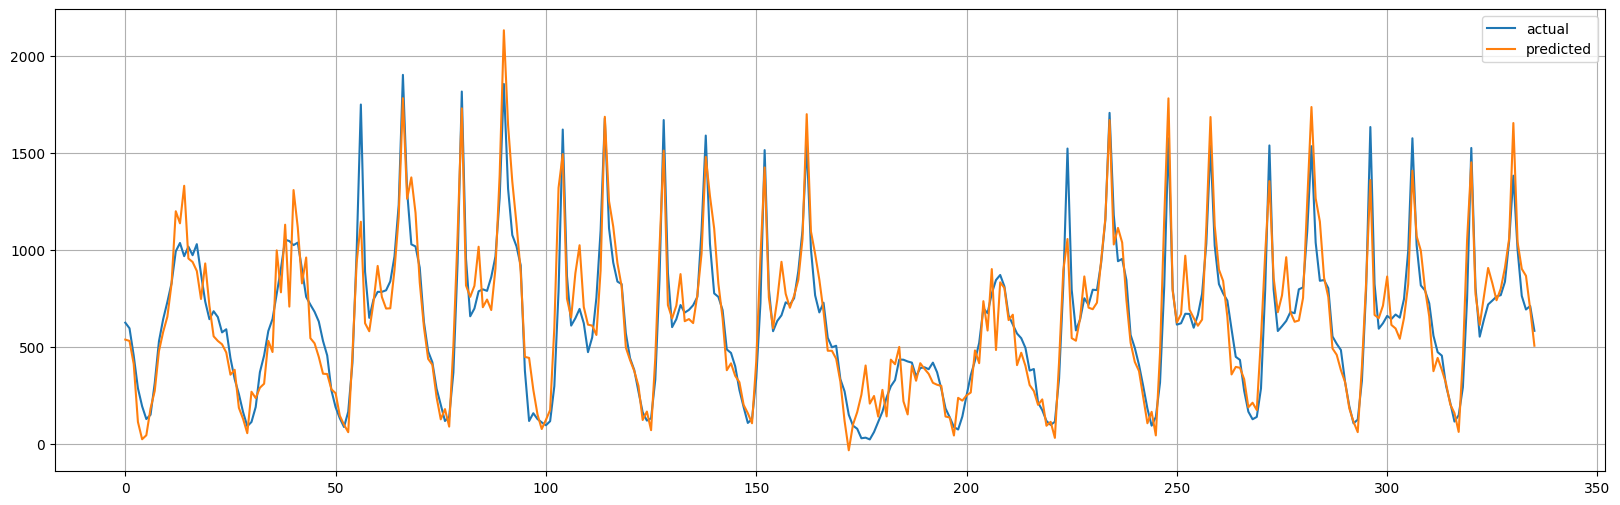

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(y_val_real, label = 'actual')
plt.plot(pred_real, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 4.모델링2



### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
x_train.shape

(8411, 12, 41)

In [ ]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계

In [ ]:
clear_session()

model = Sequential([Input(shape = (timesteps, nfeatures)),
                    LSTM(64, return_sequences = True),
                    LSTM(16, return_sequences = True),
                    LSTM(4, return_sequences = True),
                    Flatten(),
                    Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 64)              │          27,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 12, 16)              │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 4)               │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,705 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.001), loss='mse')
history = model.fit(x_train, y_train, epochs = 100, batch_size = 128,
                    validation_split=.2).history

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0330 - val_loss: 0.0197
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0119 - val_loss: 0.0148
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0085 - val_loss: 0.0127
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0070 - val_loss: 0.0121
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0063 - val_loss: 0.0128
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0060 - val_loss: 0.0118
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0052 - val_loss: 0.0113
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0055 - val_loss: 0.0108
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0048 - val_loss: 0.0107
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0047 - val_loss: 0.0104
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step

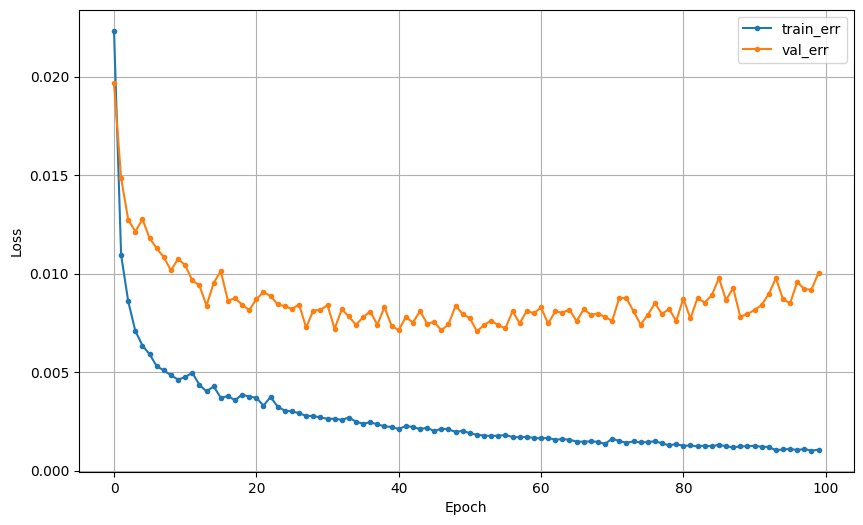

In [ ]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [ ]:
# 예측
pred = model.predict(x_val)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
# y를 스케일링 했으므로 돌려놓기
y_val_real = y_val * (y_max-y_min) + y_min
pred_real = pred * (y_max-y_min) + y_min

In [ ]:
# 평가
print(mean_squared_error(y_val_real, pred_real, squared=False))
print(mean_absolute_error(y_val_real, pred_real))
print(mean_absolute_percentage_error(y_val_real, pred_real))

349.1914787838855
263.8334009092124
0.6201938997282985


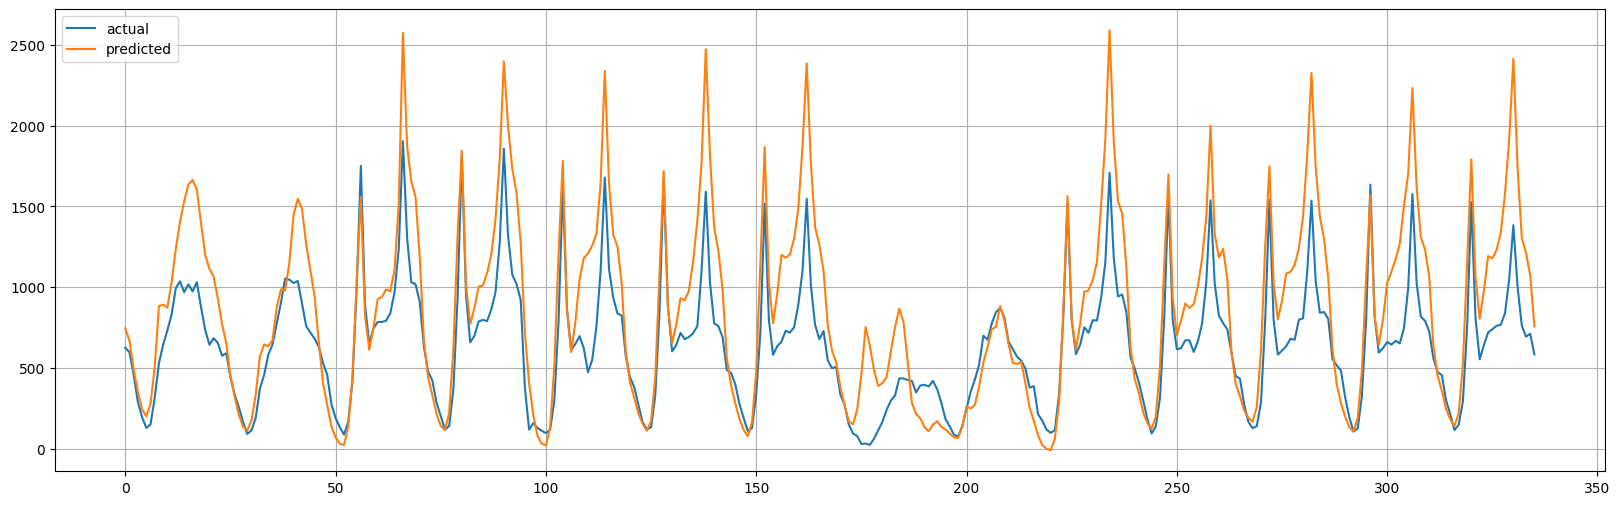

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(y_val_real, label = 'actual')
plt.plot(pred_real, label = 'predicted')
plt.legend()
plt.grid()
plt.show()